# Style Transfer Photo Booth

This notebook runs an example of style transfer using a webcam as both the content image and style.

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [3]:
%matplotlib inline

For this example we will used the VGG19 pretrained model.

This model is split into two portions **vgg19.features** and **vgg19.classifier**.

We want to look at the **vgg19.features** but also want to freeze the weights of the pretrained model.

In [2]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\Tliimfee/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth
100.0%


Move the model to the gpu if one is available

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Next we need to load images and transform / scale them so that vgg will accept them. 

Normalised values come form vgg documentation, as do max_size of 400.

In [11]:
def load_and_transform_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    size = min(max(image.size),max_size) if not shape else shape
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    
    #discard the transparent, alpha channel (:3) if any and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    return image

Now we need to get the content and style image. 

This need to be replaced with the webcam code.

In [12]:
content = load_and_transform_image('example_images/example_content.jpg').to(device)

#Resize the style image to be the same as the content because I'm lazy and it's easier.
style = load_and_transform_image('example_images/example_style.jpg',shape=content.shape[-2:]).to(device)

Unnormalise the image and display it for debugging purposes.
Both source image and content should be the same dimensions.

In [13]:
def inverse_tranform_image(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

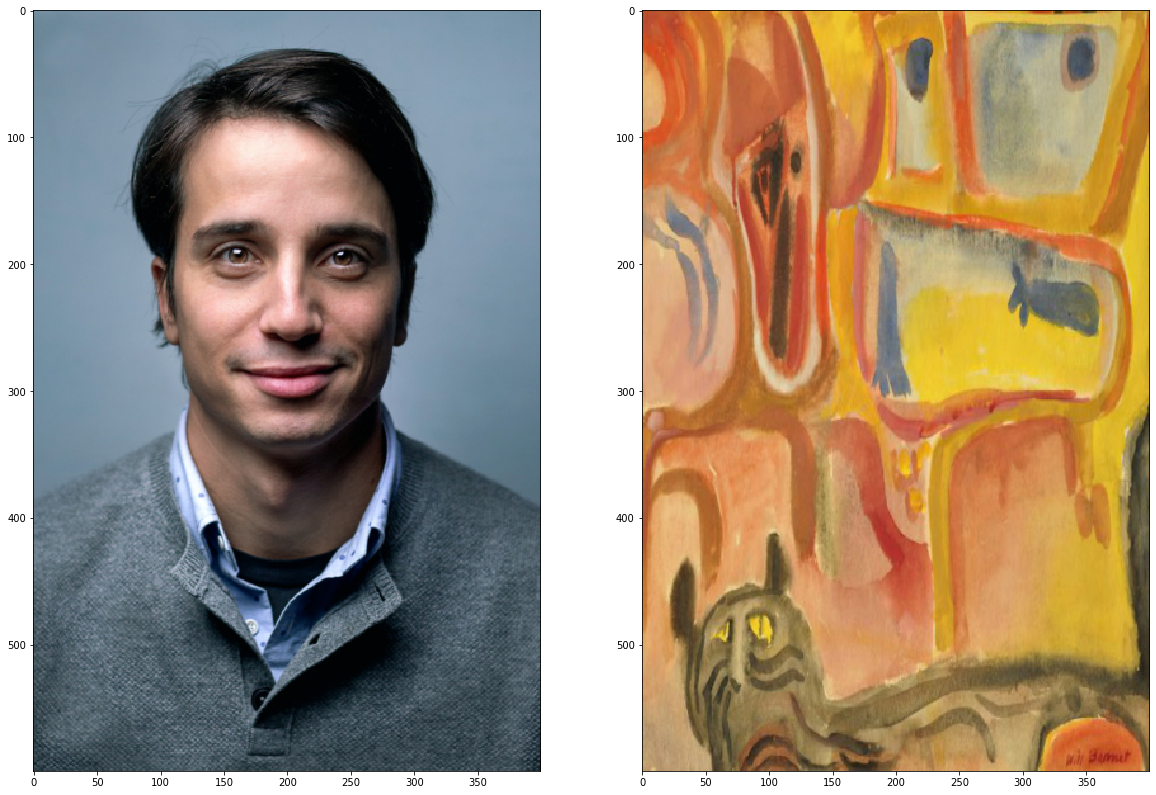

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(inverse_tranform_image(content))
ax2.imshow(inverse_tranform_image(style))

Map the layer numbers to their corresponding names. These layers were chosen based on the style transfer paper. (#TODO - add reference to paper)

In [18]:
style_transfer_layers = {'0': 'conv1_1',
                         '5': 'conv2_1', 
                         '10': 'conv3_1', 
                         '19': 'conv4_1',
                         '21': 'conv4_2',
                         '28': 'conv5_1'}

In [19]:
def get_features(image, model):
    features = {}
    x = image
    for name,layer in model._modules.items():
        x = layer(x)
        if name in style_transfer_layers:
            features[style_transfer_layers[name]] = x
    return features

Next as per the paper we need to calculate the gram matrix.

Reshape to multiplu ethe features of each channel.

In [20]:
def get_gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram 

Now we need to create the target image.

In [21]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

style_grams = {layer: get_gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

Now we need to define initial weights for the style weights, content image and style image

In [22]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.3,
                 'conv4_1': 0.3,
                 'conv5_1': 0.3}

content_weight = 1
style_weight = 1e5

Now we just train the image for a certain number of steps and print the image every now and then.

In [ ]:
def get_total_loss():
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = get_gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
    total_loss = content_weight * content_loss + style_weight * style_loss

Total loss:  4503803.0


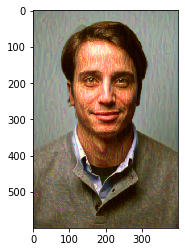

Total loss:  1335851.625


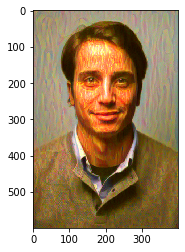

Total loss:  449174.375


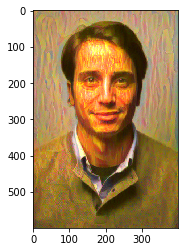

Total loss:  188658.375


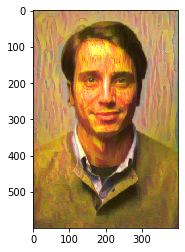

Total loss:  101341.5546875


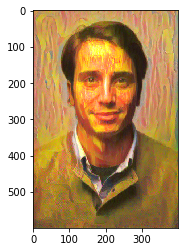

In [24]:
optimizer = optim.Adam([target], lr=0.001)
steps = 1000  

for i in range(1, steps+1):
    total_loss = get_total_loss()
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  i % show_every == 0:
        plt.imshow(im_convert(target))
        plt.show()

Display the content and the fimal target image.

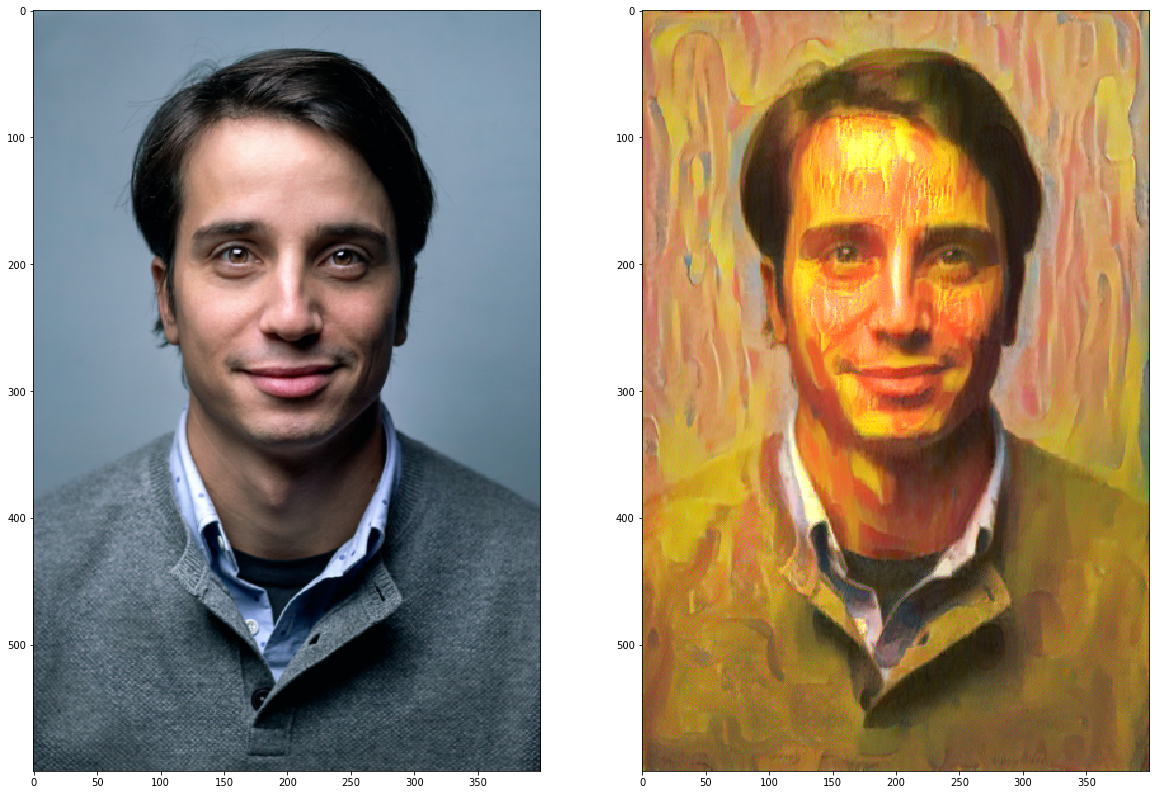

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))